# 房价预测案例
## Step 1：检视源数据集

In [1]:
import numpy as np
import pandas as pd

### 读入数据
- 一般来说源数据的id字段没什么用，可以直接用作Pandas DataFrame的index

In [2]:
train_df = pd.read_csv('../input/train.csv',index_col=0)
test_df = pd.read_csv('../input/test.csv',index_col=0)

### 检视数据

In [3]:
train_df.head() # 查看前5行数据

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


这时候大概心里有数，哪些地方需要人为处理（比方说NaN值，离散值等），以做到源数据更好的被Process

## Step 2：合并数据

这么做主要是为了用DataFrame进行数据处理的时候更加方便，等所有预处理完了之后，再分开

首先，SalePrice作为训练目标，只会出现在训练集中，不会出现在测试集（要不然你测试什么？）。所以我们要先把SalePrice这一列拿出来，不让它碍事

先看一下SalePrice长什么样：

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8d852cca58>,
      dtype=object)

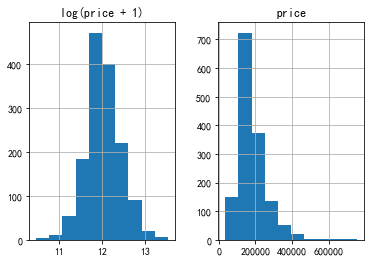

In [4]:
%matplotlib inline

prices = pd.DataFrame({
    'price':train_df['SalePrice'],
    'log(price + 1)':np.log1p(train_df['SalePrice'])
})

prices.hist()

可见，Label本身并不平滑，为了分类器的学习更加准确，我们首先要把Label“平滑化”（正态化）

这一步如果Miss掉，可能会导致最终结果达不到标准

如果这里把数据平滑化了，那么最后算结果的时候，要记得把预测的平滑数据给变回去

按照“怎么来怎么去”的原则，log1p()就需要expm1()；同理,log()就需要exp()...

log1p，也就是log(x + 1)，避免出现log(0)的问题



In [5]:
# pop出SalePrice这一列，并保存到y_train中
y_train = np.log1p(train_df.pop('SalePrice'))

然后把剩下的部分合并起来

In [6]:
all_df = pd.concat((train_df, test_df),axis = 0)

此时，all_df就是合并在一起的DataFrame

In [7]:
all_df.shape

(2919, 79)

## Step 3：变量转化

类似『特征工程』。就是把不方便处理或者不unify的数据给统一


### 正确化变量属性

首先，我们注意到，*MSSubClass* 的值是一个category

但是Pandas不懂，使用DataFrame时，这类数字符号会被默认记成数字

这就很有误导性，所以我们需要把它变回成*string*

In [8]:
all_df['MSSubClass'].dtype

dtype('int64')

In [9]:
all_df['MSSubClass'] = all_df['MSSubClass'].astype(str)

变成str以后再做个统计

In [10]:
all_df['MSSubClass'].value_counts()

20     1079
60      575
50      287
120     182
30      139
160     128
70      128
80      118
90      109
190      61
85       48
75       23
45       18
180      17
40        6
150       1
Name: MSSubClass, dtype: int64

### 把category的变量转变成numerical表达形式

当我们用数字来表达categorical的时候，要注意，数字本身有大小的含义，所以乱用数字会给之后的模型学习带来麻烦。因此我们可以用One-Hot的方法来表达category

pandas自带的get_dummies方法，可以做到一键One-Hot

In [11]:
pd.get_dummies(all_df['MSSubClass'],prefix='MSSubClass').head()

,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90
Id,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


此时MSSubClass就被分成了12个column，每一个代表一个category。是就是1，不是就是0

同理，我们要把所有的category数据都给One-Hot

In [12]:
all_dummy_df = pd.get_dummies(all_df)
all_dummy_df.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
1,65.0,8450,7,5,2003,2003,196.0,706.0,0.0,150.0,...,0,0,0,1,0,0,0,0,1,0
2,80.0,9600,6,8,1976,1976,0.0,978.0,0.0,284.0,...,0,0,0,1,0,0,0,0,1,0
3,68.0,11250,7,5,2001,2002,162.0,486.0,0.0,434.0,...,0,0,0,1,0,0,0,0,1,0
4,60.0,9550,7,5,1915,1970,0.0,216.0,0.0,540.0,...,0,0,0,1,1,0,0,0,0,0
5,84.0,14260,8,5,2000,2000,350.0,655.0,0.0,490.0,...,0,0,0,1,0,0,0,0,1,0


### 处理好numerical变量

就算是numerical的变量，也还会有一些小问题

比如，有一些数据是缺失的（NaN）：

In [13]:
all_dummy_df.isnull().sum().sort_values(ascending=False).head(11)

LotFrontage     486
GarageYrBlt     159
MasVnrArea       23
BsmtHalfBath      2
BsmtFullBath      2
BsmtFinSF2        1
GarageCars        1
TotalBsmtSF       1
BsmtUnfSF         1
GarageArea        1
BsmtFinSF1        1
dtype: int64

可以看到，缺失最多的是LotFrontage

处理这些缺失的信息，得靠好好审题。一般来说，数据集的描述里会写的很清楚，这些缺失都代表着什么。当然，如果实在没有的话，也只能靠自己的『想当然』

在这里，我们『试着』用平均值来填满这些空缺

In [14]:
mean_col = all_dummy_df.mean()
mean_col.head(10)

LotFrontage        69.305795
LotArea         10168.114080
OverallQual         6.089072
OverallCond         5.564577
YearBuilt        1971.312778
YearRemodAdd     1984.264474
MasVnrArea        102.201312
BsmtFinSF1        441.423235
BsmtFinSF2         49.582248
BsmtUnfSF         560.772104
dtype: float64

In [15]:
all_dummy_df = all_dummy_df.fillna(mean_col)

看看是不是没有空缺了

In [16]:
all_dummy_df.isnull().sum().sum()

0

### 标准化Numerical

这一步并不是必要，但是得看你想要用的分类器是什么。一般来说，regression的分类器都比较敏感，最好是把源数据给放在一个标准分布内。不要让数据间的差距太大

这里，我们不需要把One-Hot的那些0/1数据给标准化。我们的目标应该是那些本来就是numerical的数据：

先来看看 哪些是numerical的：

In [17]:
numeric_cols = all_df.columns[all_df.dtypes != 'object']
numeric_cols

Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')

计算标准分布：(X-EX) / s

让我们的数据点更平滑，更便于计算

注意：我们这里也是可以继续使用Log的，只是展示一下多种“使数据平滑”的办法

In [18]:
numeric_col_means = all_dummy_df.loc[:, numeric_cols].mean() # 均值
numeric_col_std = all_dummy_df.loc[:, numeric_cols].std() # 标准差
all_dummy_df.loc[:, numeric_cols] = (all_dummy_df.loc[:, numeric_cols] - numeric_col_means) / numeric_col_std

## Step 4：建立模型

### 把数据集分回 训练/测试集

In [19]:
dummy_train_df = all_dummy_df.loc[train_df.index]
dummy_test_df = all_dummy_df.loc[test_df.index]

In [20]:
dummy_train_df.shape, dummy_test_df.shape

((1460, 303), (1459, 303))

### Ridge Regreesion

用Ridge Regreesion模型跑一遍看看（对于多因子的数据集，这种模型可以方便的把所有的var无脑放进去）

In [21]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

这一步不是很重要，只是把DataFrame转化成Numpy Array，这样与Sklearn更相配

In [22]:
X_train = dummy_train_df.values
X_test = dummy_test_df.values
type(X_train)

numpy.ndarray

用Sklearn自带的cross validation（交叉验证）方法来测试模型

In [23]:
alphas = np.logspace(-3, 2, 50)
test_scores = []
for alpha in alphas:
    clf = Ridge(alpha)
    test_score = np.sqrt(-cross_val_score(clf, X_train, y_train, cv=10, scoring='neg_mean_squared_error'))
    test_scores.append(np.mean(test_score))

存下所有的CV值，看看哪个alpha值更好（也就是『调参数』）

Text(0.5,1,'Alpha vs CV Error')

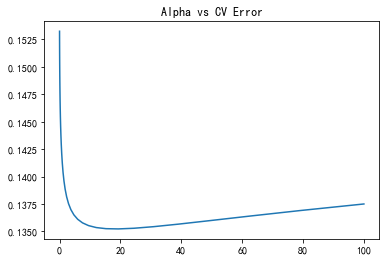

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(alphas,test_scores)
plt.title('Alpha vs CV Error')

可见，大概alpha=10～20的时候，score可以达到0.135左右

### Random Forest

In [25]:
from sklearn.ensemble import RandomForestRegressor

In [26]:
max_features = [.1, .3, .5, .7, .9, .99]
test_scores = []
for max_feat in max_features:
    clf = RandomForestRegressor(n_estimators=200, max_features=max_feat)
    test_score = np.sqrt(-cross_val_score(clf, X_train, y_train, cv=5, scoring='neg_mean_squared_error'))
    test_scores.append(np.mean(test_score))

Text(0.5,1,'Max Features vs CV Error')

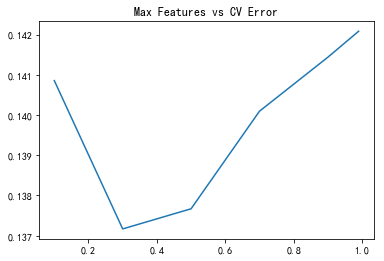

In [27]:
plt.plot(max_features, test_scores)
plt.title('Max Features vs CV Error')

## Step 5：更高级的Ensemble

一般来说，单个分类器的效果有限，于是我们倾向把N个分类器合在一起，做一个“综合分类器”，以达到更好的效果

从上面的实验得知，Ridge(alpha = 15)的效果比较好

In [44]:
from sklearn.linear_model import Ridge
ridge = Ridge(15)

### Bagging

Bagging把很多小分类器放在一起，每个train随机一部分数据，然后把它们的最终结果综合起来（多数投票制）

In [45]:
from sklearn.ensemble import BaggingRegressor
from sklearn.model_selection import cross_val_score

在这里，我们用CV结果来测试不同的分类器个数对最后结果的影响

注意，我们在部署Bagging的时候，要把它的函数base_estimator里填上小分类器（ridge）

In [50]:
params = [1, 10 ,15, 20, 25, 30, 40]
test_scores = []
for param in params:
    clf = BaggingRegressor(n_estimators=param, base_estimator=ridge)
    test_score = np.sqrt(-cross_val_score(clf,X_train,y_train,cv=10,scoring='neg_mean_squared_error'))
    test_scores.append(np.mean(test_score))

Text(0.5,1,'n_estimator vs CV Error')

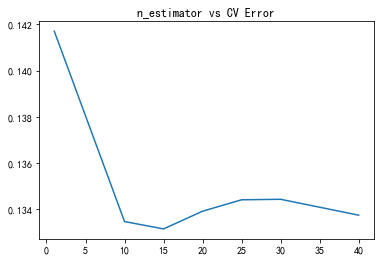

In [51]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(params,test_scores)
plt.title('n_estimator vs CV Error')

前一个粗略版本中，ridge最优结果也才0.135，而这里使用15个ridge分类器的bagging，达到了低于0.134的结果

如果你并没有提前测试过ridge模型，也可以使用Bagging自带的Decision Tree模型

代码是一样的，把base_setimator给删去即可

In [52]:
params = [10,15,20,25,30,40,50,60,70,100]
test_scores = []
for param in params:
    clf = BaggingRegressor(n_estimators=param)
    test_score = np.sqrt(-cross_val_score(clf,X_train,y_train,cv=10,scoring='neg_mean_squared_error'))
    test_scores.append(np.mean(test_score))

Text(0.5,1,'Decision Tree vs CV Error')

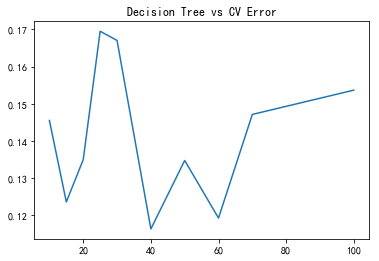

In [53]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(params, test_score)
plt.title('Decision Tree vs CV Error')

虽然从图上看Decision Tree效果更好，低于0.12，但是这里我们并不使用此模型

### Boosting

Boosting比Bagging理论上更高级点，它也是揽来一把的分类器。但是把他会将分类器进行线性排列，下一个分类器把上一个分类器分类得不好的地方加上更高的权重，这样下一个分类器就能在这个部分学得更加“深刻”

In [54]:
from sklearn.ensemble import AdaBoostRegressor

In [56]:
params = [10,15,20,25,30,35,40,45,50]
test_scores = []
for param in params:
    clf = BaggingRegressor(n_estimators=param,base_estimator=ridge)
    test_score = np.sqrt(-cross_val_score(clf,X_train,y_train,cv=10,scoring='neg_mean_squared_error'))
    test_scores.append(np.mean(test_score))

Text(0.5,1,'Boosting vs CV Error')

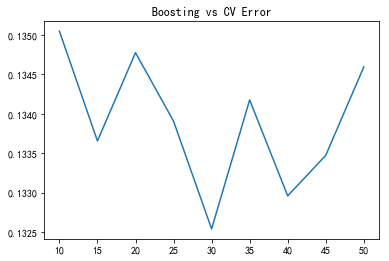

In [57]:
plt.plot(params, test_scores)
plt.title('Boosting vs CV Error')

Adaboost+Ridge在30个小分类器的情况下也是达到了接近0.1324的效果

同理，这里也可以不必输入base_estimator，使用Adaboost自带的Decision Tree

In [58]:
params = [10,15,20,25,30,35,40,45,50]
test_scores = []
for param in params:
    clf = BaggingRegressor(n_estimators=param)
    test_score = np.sqrt(-cross_val_score(clf,X_train,y_train,cv=10,scoring='neg_mean_squared_error'))
    test_scores.append(np.mean(test_score))

Text(0.5,1,'Adaboost DT vs CV Error')

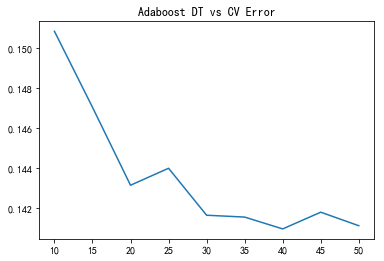

In [59]:
plt.plot(params, test_scores)
plt.title('Adaboost DT vs CV Error')

结果并不是很好，大约在0.141左右

### XGBoost

最后，我们来看看外号**Kaggle神器**的一个框架

In [60]:
from xgboost import XGBRegressor

用Sklearn自带的cross validation方法来测试模型

In [61]:
params = [1,2,3,4,5,6]
test_scores = []
for param in params:
    clf = XGBRegressor(max_depth=param)
    test_score = np.sqrt(-cross_val_score(clf,X_train,y_train,cv=10,scoring='neg_mean_squared_error'))
    test_scores.append(np.mean(test_score))

Text(0.5,1,'XGBoost vs CV Error')

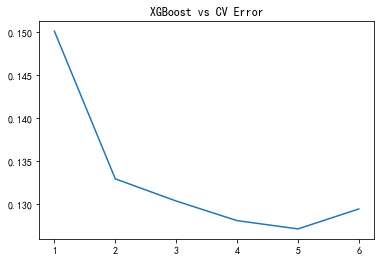

In [62]:
plt.plot(params, test_scores)
plt.title('XGBoost vs CV Error')

！！！深度为5的时候，错误率缩小到0.127